In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import xgboost

In [3]:
import pickle

In [4]:
import util

In [5]:
import matplotlib.pyplot as plt

In [6]:
import numpy as np

# 1. Get Score from Model 07, 08

In [7]:
pred07 = util.reload('SCORE_07')
pred08 = util.reload('SCORE_08')

In [9]:
pred07['CUSTOMER_CDE'].nunique(), pred08['CUSTOMER_CDE'].nunique()

(15950734, 16022576)

# 2. Get label

In [10]:
gt07 = util.reload('LABEL_07')
gt08 = util.reload('LABEL_08')

In [11]:
df07 = pred07.merge(gt07[['CUSTOMER_CDE', 'FTR_VAL']], how='left', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')
df07 = df07.rename(columns={'FTR_VAL': 'REACTIVATED'})
df07 = df07.dropna()

df08 = pred08.merge(gt08[['CUSTOMER_CDE', 'FTR_VAL']], how='left', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')
df08 = df08.rename(columns={'FTR_VAL': 'REACTIVATED'})
df08 = df08.dropna()

In [13]:
df07['REACTIVATED'].value_counts(), df08['REACTIVATED'].value_counts()

(0.0    7526338
 1.0      62660
 Name: REACTIVATED, dtype: int64,
 0.0    7545668
 1.0      33998
 Name: REACTIVATED, dtype: int64)

In [14]:
df07['REACTIVATED'].value_counts(normalize=True), df08['REACTIVATED'].value_counts(normalize=True)

(0.0    0.991743
 1.0    0.008257
 Name: REACTIVATED, dtype: float64,
 0.0    0.995515
 1.0    0.004485
 Name: REACTIVATED, dtype: float64)

# Plot histogram

In [15]:
import seaborn as sns

In [16]:
# sns.kdeplot(df4, hue='REACTIVATED', x='SCORE', common_norm=False)

In [17]:
from sklearn import metrics

In [18]:
y_true = df07['REACTIVATED'].values
y_pred = df07['SCORE'].values

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

0.9801699335983436

In [20]:
fpr, tpr, thresholds = metrics.roc_curve(df08['REACTIVATED'].values, df08['SCORE'].values)
metrics.auc(fpr, tpr)

0.9569338189915221

## Plot AUC

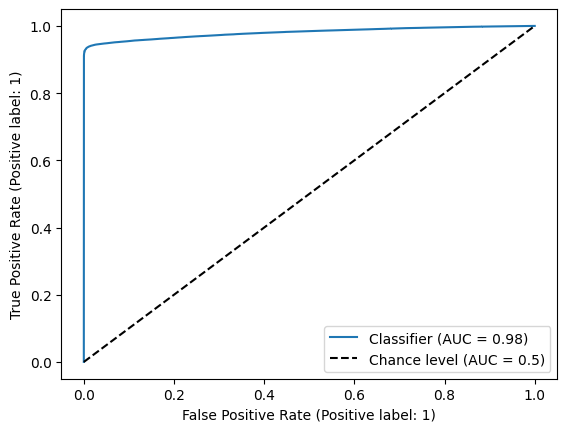

In [21]:
display = metrics.RocCurveDisplay.from_predictions(y_true, y_pred, plot_chance_level=True)

In [23]:
df07.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7588998 entries, 0 to 15950733
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   CUSTOMER_CDE  object 
 1   SCORE         float64
 2   REACTIVATED   float64
dtypes: float64(2), object(1)
memory usage: 231.6+ MB


In [24]:
df08.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7579666 entries, 86 to 16022574
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   CUSTOMER_CDE  object 
 1   SCORE         float64
 2   REACTIVATED   float64
dtypes: float64(2), object(1)
memory usage: 231.3+ MB


# CAP & Gini & Lift

In [94]:
df = df07.copy()
df = df.rename(columns={'SCORE': 'PROBA_REACTIVE', 'REACTIVATED': 'LABEL'})
df['PROBA_NOREACTIVE'] = 1 - df['PROBA_REACTIVE']
df['LABEL'] = df['LABEL'].apply(lambda x: 'REACTIVATED' if x == 1 else 'NOT_REACTIVATED')

In [95]:
df = df.sort_values(by='PROBA_NOREACTIVE')

In [96]:
qcuts, bins = pd.qcut(df['PROBA_NOREACTIVE'], q=100, labels=False, retbins=True)

In [97]:
df['bin'] = qcuts

# num_bins = 100
# bucket_size = len(df) // num_bins
# buckets = [i for i in range(num_bins) for j in range(bucket_size)] + [num_bins-1] * (len(df) % num_bins)
# df['bin'] = buckets

In [98]:
df = df.groupby('bin')['LABEL'].value_counts().to_frame(name='count').reset_index().pivot(index='bin', columns='LABEL', values='count')
df['NOT_REACTIVATED'] = df['NOT_REACTIVATED'].fillna(0)

In [99]:
df['total_lead'] = df['REACTIVATED'] + df['NOT_REACTIVATED']

In [100]:
total_reactivated = df['REACTIVATED'].sum()
total_leads = df['total_lead'].sum()
total_leads, total_reactivated

(7588998, 62660)

In [101]:
df['perc_REACTIVATED'] = df['REACTIVATED'] / total_reactivated * 100
df['cumsum_REACTIVATED'] = df['REACTIVATED'].cumsum()
df['perc_cumsum_REACTIVATED'] = df['cumsum_REACTIVATED'] / total_reactivated * 100
df['lift'] = df['perc_cumsum_REACTIVATED'] / (df['total_lead'].cumsum() / total_leads)  / 100

In [102]:
df = df[['total_lead', 'REACTIVATED', 'cumsum_REACTIVATED', 'perc_REACTIVATED', 'perc_cumsum_REACTIVATED', 'lift']]

In [103]:
df = df.reset_index()

In [104]:
df

LABEL,bin,total_lead,REACTIVATED,cumsum_REACTIVATED,perc_REACTIVATED,perc_cumsum_REACTIVATED,lift
0,0,75890,58112,58112,92.741781,92.741781,92.741757
1,1,75891,738,58850,1.177785,93.919566,46.959461
2,2,75889,257,59107,0.410150,94.329716,31.443230
3,3,75890,137,59244,0.218640,94.548356,23.637083
4,4,75912,113,59357,0.180338,94.728695,18.944636
...,...,...,...,...,...,...,...
95,95,77036,8,62615,0.012767,99.928184,1.040755
96,96,75728,13,62628,0.020747,99.948931,1.030263
97,97,75167,9,62637,0.014363,99.963294,1.019998
98,98,76059,8,62645,0.012767,99.976061,1.009801


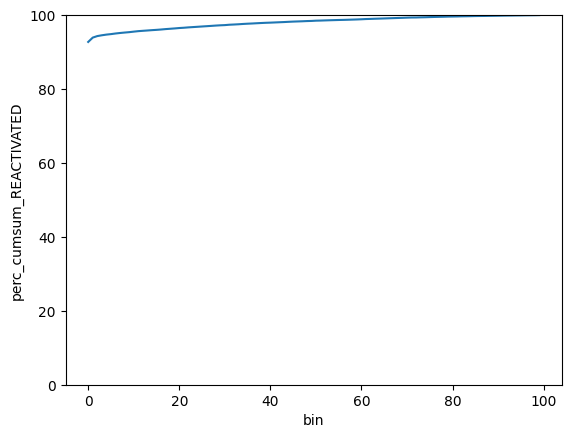

In [105]:
ax = sns.lineplot(df[['bin', 'perc_cumsum_REACTIVATED']], x='bin', y='perc_cumsum_REACTIVATED')
ax.set_ylim(0, 100)
plt.show()

## Make Prediction on Backtest 08

In [106]:
df1 = df08.copy()
df1 = df1.rename(columns={'SCORE': 'PROBA_REACTIVE', 'REACTIVATED': 'LABEL'})
df1['PROBA_NOREACTIVE'] = 1 - df1['PROBA_REACTIVE']
df1['LABEL'] = df1['LABEL'].apply(lambda x: 'REACTIVATED' if x == 1 else 'NOT_REACTIVATED')

In [107]:
df1 = df1.sort_values(by='PROBA_NOREACTIVE')

In [108]:
df1['bin'] = pd.cut(df1['PROBA_NOREACTIVE'], bins=bins, labels=False)

In [109]:
df1 = df1.groupby('bin')['LABEL'].value_counts().to_frame(name='count').reset_index().pivot(index='bin', columns='LABEL', values='count')
df1['NOT_REACTIVATED'] = df1['NOT_REACTIVATED'].fillna(0)

In [110]:
df1['total_lead'] = df1['REACTIVATED'] + df1['NOT_REACTIVATED']

In [111]:
total_reactivated = df1['REACTIVATED'].sum()
total_leads = df1['total_lead'].sum()
total_leads, total_reactivated

(7579662, 33995)

In [112]:
df1['perc_REACTIVATED'] = df1['REACTIVATED'] / total_reactivated * 100
df1['cumsum_REACTIVATED'] = df1['REACTIVATED'].cumsum()
df1['perc_cumsum_REACTIVATED'] = df1['cumsum_REACTIVATED'] / total_reactivated * 100
df1['lift'] = df1['perc_cumsum_REACTIVATED'] / (df1['total_lead'].cumsum() / total_leads)  / 100

In [113]:
df1 = df1[['total_lead', 'REACTIVATED', 'cumsum_REACTIVATED', 'perc_REACTIVATED', 'perc_cumsum_REACTIVATED', 'lift']]

In [114]:
df1 = df1.reset_index()

In [115]:
df1

LABEL,bin,total_lead,REACTIVATED,cumsum_REACTIVATED,perc_REACTIVATED,perc_cumsum_REACTIVATED,lift
0,0.0,47001,29154,29154,85.759671,85.759671,138.301167
1,1.0,74173,606,29760,1.782615,87.542286,54.759349
2,2.0,74599,243,30003,0.714811,88.257097,34.170134
3,3.0,77827,160,30163,0.470657,88.727754,24.580643
4,4.0,76149,155,30318,0.455949,89.183703,19.327641
...,...,...,...,...,...,...,...
95,95.0,80869,21,33937,0.061774,99.829387,1.040160
96,96.0,72004,12,33949,0.035299,99.864686,1.030330
97,97.0,74123,13,33962,0.038241,99.902927,1.020429
98,98.0,80635,18,33980,0.052949,99.955876,1.009995


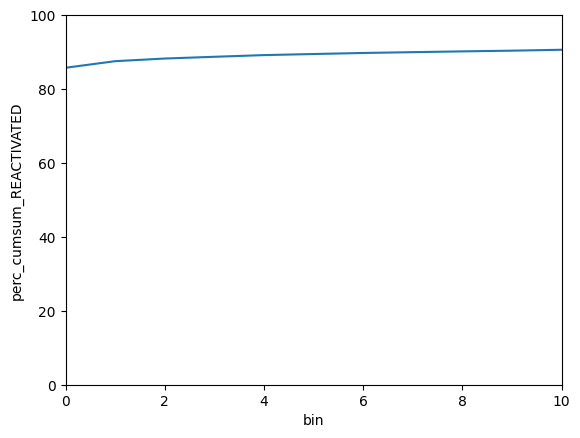

In [116]:
ax = sns.lineplot(df1[['bin', 'perc_cumsum_REACTIVATED']], x='bin', y='perc_cumsum_REACTIVATED')
ax.set_ylim(0, 100)
ax.set_xlim(0, 10)
plt.show()